<a href="https://colab.research.google.com/github/DVAEsCL/DVAEsCL/blob/main/CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download the CIFAR100 dataset

In [ ]:
import torch
import torchvision

batch_size_train = 50000
batch_size_test = 10000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR100('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR100('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

examples_t = enumerate(test_loader)
batch_idx_t, (example_data_t, example_targets_t) = next(examples_t)
print(example_data_t.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


We are converting the dataset into five tasks and storing it in some JSON files to use in the future again and again so that we do not need to download the dataset always. Later, we can extract it from the driver to train and test models when we need the data. Though, we added a link for the zip file, so please skip the first few steps.

In [ ]:
def get_indices(example_targets, num_class = 100, num_task = 5):
  indices_list = [[] for i in range(num_task)]

  class_list = [[] for i in range(num_task)]
  val = 0
  for i in range(num_task):
    for j in range(int(num_class/num_task)):
      class_list[i].append(val + j)
    val = val + j + 1

  for i in range(example_targets.shape[0]):
    for j in range(num_task):
      if example_targets[i].item() in class_list[j]:
        indices_list[j].append(i)
      else:
        continue
  #print(class_list)
  return indices_list
  

In [ ]:
  class_list = [[] for i in range(20)]
  val = 0
  for i in range(20):
    for j in range(int(100/20)):
      class_list[i].append(val + j)
    val = val + j +1 
print(class_list)

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17, 18, 19], [20, 21, 22, 23, 24], [25, 26, 27, 28, 29], [30, 31, 32, 33, 34], [35, 36, 37, 38, 39], [40, 41, 42, 43, 44], [45, 46, 47, 48, 49], [50, 51, 52, 53, 54], [55, 56, 57, 58, 59], [60, 61, 62, 63, 64], [65, 66, 67, 68, 69], [70, 71, 72, 73, 74], [75, 76, 77, 78, 79], [80, 81, 82, 83, 84], [85, 86, 87, 88, 89], [90, 91, 92, 93, 94], [95, 96, 97, 98, 99]]


In [ ]:
import json
train_indices = get_indices(example_targets, 100, 20)
test_indices = get_indices(example_targets_t, 100, 20)

traindata_list =[]
trainlabels_list = []
testdata_list = []
testlabels_list = []
#5
for j in range(20):
  traindata = example_data[train_indices[j]]
  trainlabels = example_targets[train_indices[j]]
  testdata = example_data_t[test_indices[j]]
  testlabels = example_targets_t[test_indices[j]]
  testdata_list.append(testdata.numpy().tolist())
  testlabels_list.append(testlabels.numpy().tolist())
  traindata_list.append(traindata.detach().numpy().tolist())
  trainlabels_list.append(trainlabels.numpy().tolist())

with open('traindata_20.json', 'w') as jsonfile:
    json.dump(traindata_list, jsonfile)
with open('trainlabels_20.json', 'w') as jsonfile:
    json.dump(trainlabels_list, jsonfile)
with open('testdata_20.json', 'w') as jsonfile:
    json.dump(testdata_list, jsonfile)
with open('testlabels_20.json', 'w') as jsonfile:
    json.dump(testlabels_list, jsonfile)

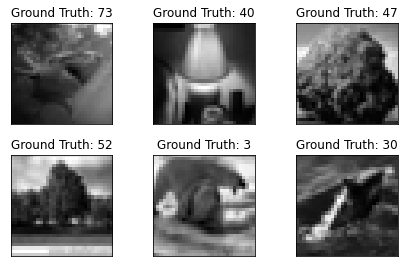

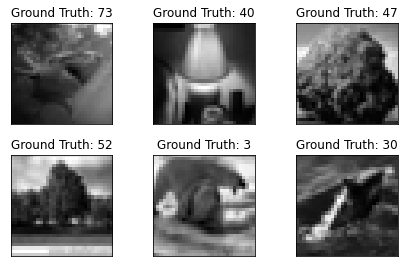

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

#If you download the zip file start from here
Please download the zip file, extracts four files and upload to a drive(your_path). Please click [here](https://drive.google.com/drive/folders/1gxdWtxZukJciHFqOFwx9-UJ8XeimdCue?usp=sharing) to download the data.


In [3]:
import torch
import torch.nn as nn
class encoder(nn.Module):
  def __init__(self):
    super(encoder, self).__init__()
    self.nc_mnist = 1
    self.nc_cifar10 = 3
    self.conv1 = nn.Conv2d(self.nc_cifar10, 3, 3, 1, 1) 
    self.conv2 = nn.Conv2d(3, 6, 2, 2, 0)
    self.conv3 = nn.Conv2d(6, 12, 2, 2, 0)
    self.conv4 = nn.Conv2d(12, 24, 2, 2, 0)
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    return x
class decoder(nn.Module):
  def __init__(self):
    super(decoder, self).__init__()
    self.nc_mnist = 118
    self.nc_cifar10 = 202
    self.nc_cifar100 = 292
    self.nk_mnist = 3
    self.nk_cifar10 = 4
    self.decon1 = nn.ConvTranspose2d(self.nc_cifar100, 24, 3, 1, 0)
    self.decon2 = nn.ConvTranspose2d(24, 12, self.nk_cifar10, 2, 0)
    self.decon3 = nn.ConvTranspose2d(12, 6, 2, 2, 0)
    self.decon4 = nn.ConvTranspose2d(6, 3, 2, 2, 0)
  def forward(self, x):
    x = x.view(x.shape[0], self.nc_cifar100, 1, 1)
    x = self.decon1(x)
    x = self.decon2(x)
    x = self.decon3(x)
    x = self.decon4(x)
    return x

class VAE(nn.Module):
  def __init__(self, eps):
    super(VAE, self).__init__()
    self.en = encoder()
    self.de = decoder()
    self.eps = eps
    self.mnist_z = 108
    self.cifar10_z = 192
  def forward(self, x, one_hot):
    x = self.en(x)
    x = x.view(x.shape[0], -1)
    mu = x[:, :self.cifar10_z]
    logvar = x[:, self.cifar10_z:]
    std = torch.exp(0.5 * logvar)
    z = mu + self.eps * std
    #print(z.shape, 'aaa', one_hot.shape)
    z1 = torch.cat((z, one_hot), axis = 1)
    #print(z1.shape, 'bbb')
    return self.de(z1), mu, logvar

class private(nn.Module):
  def __init__(self, eps):
    super(private, self).__init__()
    self.task = torch.nn.ModuleList()
    self.eps = eps
    for _ in range(20):
      self.task.append(VAE(self.eps))

  def forward(self, x, one_hot, task_id):
    return self.task[task_id].forward(x, one_hot)

class NET(nn.Module):
  def __init__(self, eps):
    super(NET, self).__init__()
    self.eps = eps
    self.shared = VAE(self.eps)
    self.private = private(self.eps)
    self.head = torch.nn.ModuleList()
    self.mnist = 216
    self.cifar10 = 384
    self.in_mnist = 2
    self.in_cifar10 = 6
    for _ in range(20):
      self.head.append(
          nn.Sequential(
            nn.Conv2d(self.in_cifar10, 12, 3, 1, 1),
            #nn.Conv2d(3, 6, 2, 2, 0),
            #nn.Conv2d(6, 12, 2, 2, 0),
            nn.Conv2d(12, 24, 2, 2, 0),
            nn.Flatten(1, -1),
            nn.Linear(24*16*16, 100), #for cifar10 only
            #nn.Linear(100, 10)
          )
      )

  def forward(self, x, one_hot, task_id):
    s_x, s_mu, s_logvar = self.shared(x, one_hot)
    p_x, p_mu, p_logvar = self.private(x, one_hot, task_id)
    #print(s_x.shape, p_x.shape, '111')
    x = torch.cat([s_x, p_x], dim = 1)
    #print(x.shape, '22')
    return self.head[task_id].forward(x), (s_x, s_mu, s_logvar), (p_x, p_mu, p_logvar)


#Number of epochs and synthetic data
If you wish to change the number of epochs and synthetic data used as a generative replay, check lines 115 and 64, respectively. Change according to your requirments.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from collections import deque
from torch.autograd import grad as torch_grad

import torchvision.utils as vutils

import os
import os.path

class CL_VAE():
  def __init__(self):
    super(CL_VAE, self).__init__()

    self.batch_size = 64
    self.mnist_z = 108
    self.cifar10_z = 192
    self.num_class_cifar100 = 100
    self.num_class_cifar10 = 10
    self.build_model()
    self.set_cuda()
    self.criterion = torch.nn.CrossEntropyLoss()
    self.recon = torch.nn.MSELoss()
    self.net_path = 'path/trial.pth'
    self.acc_matr = []
    self.forget_mat = []
    self.acc_25 = []
    self.acc_50 = []
    self.accuracy_matrix = [[] for kk in range(20)]

  def build_model(self):
    self.eps = torch.randn(self.batch_size, self.cifar10_z)
    self.eps = self.eps.cuda()
    self.net = NET(self.eps)
    pytorch_total_params = sum(p.numel() for p in self.net.parameters() if p.requires_grad)
    print('pytorch_total_params:', pytorch_total_params)
    
  def set_cuda(self):
    self.net.cuda()



  def VAE_loss(self, recon, mu, sigma):
    kl_div = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    #print('kl_div', kl_div.item())
    return recon + kl_div

  def train(self, all_traindata, all_trainlabels, all_testdata, all_testlabels, total_tasks):
    replay_classes = []
    for i in range(total_tasks):
      traindata = torch.tensor(all_traindata[i])
      trainlabels = torch.tensor(all_trainlabels[i])
      testdata = torch.tensor(all_testdata[i])
      testlabels = torch.tensor(all_testlabels[i])
      #print(trainlabels, 'avfr')
      replay_classes.append(sorted(list(set(trainlabels.numpy().tolist()))))
      if i + 1 == 1:
        self.train_task(traindata, trainlabels, testdata, testlabels, i)
        #replay_classes.append(sorted(list(set(trainlabels.detach().numpy().tolist()))))
      else:
        num_gen_samples = 4
        #z_dim = 108
        for m in range(i):
          #print(replay_classes, 'replay_classes')
          replay_trainlabels = []
          for ii in replay_classes[m]:
            for j in range(num_gen_samples):
              replay_trainlabels.append(ii)
          replay_trainlabels = torch.tensor(replay_trainlabels)
          replay_trainlabels_onehot = self.one_hot(replay_trainlabels)



          z = torch.randn(5 * num_gen_samples, self.cifar10_z)
          #print(z.shape, replay_trainlabels_onehot.shape, 'aa')
          z_one_hot = torch.cat((z, replay_trainlabels_onehot), axis = 1)
          z_one_hot = z_one_hot.cuda()
          replay_data = self.net.private.task[m].de(z_one_hot).detach().cpu()

          traindata = torch.cat((replay_data, traindata), axis = 0)
          trainlabels = torch.cat((replay_trainlabels, trainlabels))
          testdata = torch.cat((testdata, torch.tensor(all_testdata[m])), axis = 0)
          testlabels = torch.cat((testlabels, torch.tensor(all_testlabels[m])))
        #print(trainlabels.shape, 'aaa', i + 1)
        self.train_task(traindata, trainlabels, testdata, testlabels, i)
      self.acc_mat(all_testdata, all_testlabels, total_tasks, i)
      
      #print(sorted(list(set(trainlabels.detach().numpy()))), '/n', sorted(list(set(testlabels.detach().numpy()))))
    self.forgetting_measure(self.accuracy_matrix, total_tasks)
    #print(np.mean(np.array(self.forget_mat)), 'forget_mat:', self.forget_mat)
    #print(self.acc_25, 'acc_25', np.mean(self.acc_25))
    #print(self.acc_50, 'acc_50', np.mean(self.acc_50))



  def one_hot(self, labels):
    matrix = torch.zeros(len(labels), self.num_class_cifar100)
    rows = np.arange(len(labels))
    matrix[rows, labels] = 1
    return matrix 

  def model_save(self):
    torch.save(self.net.state_dict(), os.path.join(self.net_path))


  def train_task(self, traindata, trainlabels, testdata, testlabels, task_id):

    net_opti = torch.optim.Adam(self.net.parameters(), lr = 1e-4)
    #data, label = traindata
    #batch_size = 64
    num_iterations = int(traindata.shape[0]/self.batch_size)
    num_epochs = 50
    #print(num_iterations, '451')
    for e in range(num_epochs):
      for i in range(num_iterations):
        self.net.zero_grad()
        self.net.train()
        

        batch_data = traindata[i * self.batch_size : (i + 1)*self.batch_size]
        #print(batch_data.shape, '41')
        batch_label = trainlabels[i * self.batch_size : (i + 1)*self.batch_size]
        batch_label_one_hot = self.one_hot(batch_label)
        batch_data = batch_data.cuda()
        batch_label = batch_label.cuda()
        batch_label_one_hot = batch_label_one_hot.cuda()

        out, shared_out, private_out = self.net(batch_data, batch_label_one_hot, task_id)
        s_x, s_mu, s_logvar = shared_out
        p_x, p_mu, p_logvar = private_out
        #print(out.shape, '12', batch_label.shape, s_x.shape)

        cross_en_loss = self.criterion(out, batch_label)

        s_recon = self.recon(batch_data, s_x)
        p_recon = self.recon(batch_data, p_x)

        s_VAE_loss = self.VAE_loss(s_recon, s_mu, s_logvar)
        p_VAE_loss = self.VAE_loss(p_recon, p_mu, p_logvar)

        all_loss = cross_en_loss + s_VAE_loss + p_VAE_loss

        all_loss.backward(retain_graph=True)
        net_opti.step()
      #print('epoch:', e + 1, 'task_loss', cross_en_loss.item(), 's_VAE:', s_VAE_loss.item(), 'p_VAE', p_VAE_loss.item())

      if (e + 1) % 25 == 0:

        if task_id + 1 == 20:
          self.model_save()
      
      if e + 1 == 25:
        self.acc_25.append(acc1)
      if e + 1 == 50:
        self.acc_50.append(acc1)
      
    #self.acc_matr.append(acc1)

  def forgetting_measure(self, accuracy_matrix, num_tasks):
    forgetting_measure = []
    accuracy_matrix = np.array(accuracy_matrix)
    for after_task_idx in range(1, num_tasks):
      after_task_num = after_task_idx + 1
      #print(accuracy_matrix, 'accuracy_matrix')
      prev_acc = accuracy_matrix[:after_task_num - 1, :after_task_num - 1]
      forgettings = prev_acc.max(axis=0) - accuracy_matrix[after_task_num - 1, :after_task_num - 1]
      forgetting_measure.append(np.mean(forgettings).item())
    
    #print('forgetting_measure', forgetting_measure)
    #print("the forgetting measure is...", np.mean(np.array(forgetting_measure)))

  def acc_mat(self, testData1, testLabels1, num_tasks, t):
    for kk in range(num_tasks):
      testData_tw = torch.tensor(testData1[kk])
      testLabels_tw = torch.tensor(testLabels1[kk])
      testLabels_tw_classes = sorted(list(set(testLabels_tw.detach().numpy().tolist())))
      #pred_tw = (class_appr.test(testData_tw)).cpu() #classifier.predict(testData_tw)
      _, pred_tw = self.evall(testData_tw, testLabels_tw, kk)
      #pred_tw = torch.argmax(pred_tw, dim = 1) 
      #pred_tw = pred_tw.cpu()       
      testLabels_tw = testLabels_tw.detach().numpy()[:pred_tw.shape[0]]
      #print(pred_tw[0], '12', testLabels_tw[0])
      dict_correct_tw = {}
      dict_total_tw = {}

      for ii in testLabels_tw_classes:
        dict_total_tw[ii] = 0
        dict_correct_tw[ii] = 0

      for ii in range(0, testLabels_tw.shape[0]):
        #print(testLabels_tw[ii],'aaa', pred_tw[ii])
        if(testLabels_tw[ii] == pred_tw[ii]):
          dict_correct_tw[testLabels_tw[ii].item()] = dict_correct_tw[testLabels_tw[ii].item()] + 1
        #print(testLabels_tw[ii], '1', dict_total_tw[testLabels_tw[ii]], '2', dict_total_tw[testLabels_tw[ii]])
        dict_total_tw[testLabels_tw[ii].item()] = dict_total_tw[testLabels_tw[ii].item()] + 1
            
      avgAcc_tw = 0.0
      num_seen_tw = 0.0
        
      for ii in testLabels_tw_classes:
        avgAcc_tw = avgAcc_tw + (dict_correct_tw[ii]*1.0)/(dict_total_tw[ii])
        num_seen_tw = num_seen_tw + 1
        
      avgAcc_tw = avgAcc_tw/num_seen_tw
        
      #testData_tw[jj].append(avgAcc_tw)
      self.accuracy_matrix[t].append(avgAcc_tw)
      

  def evall(self, testdata, testlabels, task_id):
    self.net.eval()
    num_iterations = int(testdata.shape[0]/self.batch_size)
    acc = []
    pred_labels_list = []
    for i in range(num_iterations):
      batch_data = testdata[i * self.batch_size : (i + 1) * self.batch_size]
      batch_labels = testlabels[i * self.batch_size : (i + 1) * self.batch_size]
      batch_label_one_hot = self.one_hot(batch_labels)
      batch_data = batch_data.cuda()
      batch_labels = batch_labels.cuda()
      batch_label_one_hot = batch_label_one_hot.cuda()
      out, _, _ = self.net(batch_data, batch_label_one_hot, task_id)
      pred_labels = torch.argmax(out, axis = 1)
      #print(pred_labels, 'aa')
      #print(pred_labels.shape, '1452', batch_labels)
      pred_labels_list.append(pred_labels.detach().cpu().numpy().tolist())
      acc.append((torch.sum(batch_labels == pred_labels)/batch_data.shape[0] * 100).detach().cpu().numpy().tolist())
    #print('acc:', acc)
    return np.mean(np.array(acc)), np.array(pred_labels_list).flatten()


In [1]:
import json
traindata_path = '/content/drive/MyDrive/ColabNotebooks/ContinualLearning/traindata_20.json'
trainlabels_path = '/content/drive/MyDrive/ColabNotebooks/ContinualLearning/trainlabels_20.json'
testdata_path = '/content/drive/MyDrive/ColabNotebooks/ContinualLearning/testdata_20.json'
testlabels_path = '/content/drive/MyDrive/ColabNotebooks/ContinualLearning/testlabels_20.json'



In [2]:
with open(traindata_path) as f:
  traindata = json.load(f)
with open(trainlabels_path) as f:
  trainlabels = json.load(f)
with open(testdata_path) as f:
  testdata = json.load(f)
with open(testlabels_path) as f:
  testlabels = json.load(f)


In [7]:
import time
aaa = CL_VAE()
#start = time.time()

aaa.train(traindata, trainlabels, testdata, testlabels, 20)
#end = time.time()
#print('It took: ', end - start)

pytorch_total_params: 13790903
